<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [17]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [18]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      #preprocessament
      lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
      l, a, b = cv2.split(lab)
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      l_clahe = clahe.apply(l)
      lab_clahe = cv2.merge((l_clahe, a, b))
      image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [19]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [20]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [21]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  print((1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]))
  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

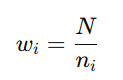

In [22]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [23]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [24]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [25]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [26]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [27]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 10
  requerit = 0.03
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 10
          last_loss = train_loss

  return model

In [28]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [29]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [30]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'alexnet'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 5:
  weights = binary_weights
else:
  weights = multiple_weights


learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":weights,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
2.845929572315279


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': 2.845929572315279}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.6380539822625924
Accuracy train epoch: 1  train_acc: 0.7897387721839912
F1 train epoch: 1  train_f1: 0.7943157750149341
Recall train epoch: 1  train_recall: 0.7897387721839912


Pèrdua validació epoch: 1  val_loss: 0.5332303000614047
Accuracy val epoch: 1  val_acc: 0.7958984375
F1 val epoch: 1  val_f1: 0.8205472597568597
Recall val epoch: 1  val_recall: 0.7958984375
Recall val epoch: 1  val_precision: 0.8862772013837725


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.5407027917435445
Accuracy train epoch: 2  train_acc: 0.8146618073161898
F1 train epoch: 2  train_f1: 0.828722180212353
Recall train epoch: 2  train_recall: 0.8146618073161898


Pèrdua validació epoch: 2  val_loss: 0.513599194586277
Accuracy val epoch: 2  val_acc: 0.8345703125
F1 val epoch: 2  val_f1: 0.842725588838846
Recall val epoch: 2  val_recall: 0.8345703125
Recall val epoch: 2  val_precision: 0.8656563971184953


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.5116294183104162
Accuracy train epoch: 3  train_acc: 0.8307112459253894
F1 train epoch: 3  train_f1: 0.8430381961564729
Recall train epoch: 3  train_recall: 0.8307112459253894


Pèrdua validació epoch: 3  val_loss: 0.4904696298763156
Accuracy val epoch: 3  val_acc: 0.8212890625
F1 val epoch: 3  val_f1: 0.8386094022824401
Recall val epoch: 3  val_recall: 0.8212890625
Recall val epoch: 3  val_precision: 0.8805488065133785


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.4890580556663384
Accuracy train epoch: 4  train_acc: 0.839788572980804
F1 train epoch: 4  train_f1: 0.8503963650654253
Recall train epoch: 4  train_recall: 0.839788572980804


Pèrdua validació epoch: 4  val_loss: 0.49075613263994455
Accuracy val epoch: 4  val_acc: 0.85625
F1 val epoch: 4  val_f1: 0.8643544487368311
Recall val epoch: 4  val_recall: 0.85625
Recall val epoch: 4  val_precision: 0.8834553639782493


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.4641043525411788
Accuracy train epoch: 5  train_acc: 0.8455383013400941
F1 train epoch: 5  train_f1: 0.8564899833081597
Recall train epoch: 5  train_recall: 0.8455383013400941


Pèrdua validació epoch: 5  val_loss: 0.48515041917562485
Accuracy val epoch: 5  val_acc: 0.8533203125
F1 val epoch: 5  val_f1: 0.8607776111559847
Recall val epoch: 5  val_recall: 0.8533203125
Recall val epoch: 5  val_precision: 0.8802593708013262


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.44869210099081597
Accuracy train epoch: 6  train_acc: 0.8558380115900036
F1 train epoch: 6  train_f1: 0.8642543264568257
Recall train epoch: 6  train_recall: 0.8558380115900036


Pèrdua validació epoch: 6  val_loss: 0.509236206067726
Accuracy val epoch: 6  val_acc: 0.8796875
F1 val epoch: 6  val_f1: 0.8788959272247526
Recall val epoch: 6  val_recall: 0.8796875
Recall val epoch: 6  val_precision: 0.8882231143952894


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.4336491947273809
Accuracy train epoch: 7  train_acc: 0.8656963056863455
F1 train epoch: 7  train_f1: 0.8741567971334165
Recall train epoch: 7  train_recall: 0.8656963056863455


Pèrdua validació epoch: 7  val_loss: 0.5076546533964574
Accuracy val epoch: 7  val_acc: 0.8865234375
F1 val epoch: 7  val_f1: 0.8805291434791066
Recall val epoch: 7  val_recall: 0.8865234375
Recall val epoch: 7  val_precision: 0.8893705019378294


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.40627448127208005
Accuracy train epoch: 8  train_acc: 0.8702802426657008
F1 train epoch: 8  train_f1: 0.8784494158006776
Recall train epoch: 8  train_recall: 0.8702802426657008


Pèrdua validació epoch: 8  val_loss: 0.49503764091059566
Accuracy val epoch: 8  val_acc: 0.8744140625
F1 val epoch: 8  val_f1: 0.8745493213169502
Recall val epoch: 8  val_recall: 0.8744140625
Recall val epoch: 8  val_precision: 0.8843258907262258


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3996055778041779
Accuracy train epoch: 9  train_acc: 0.869159724737414
F1 train epoch: 9  train_f1: 0.8771526733511281
Recall train epoch: 9  train_recall: 0.869159724737414


Pèrdua validació epoch: 9  val_loss: 0.554640278685838
Accuracy val epoch: 9  val_acc: 0.8841796875
F1 val epoch: 9  val_f1: 0.8788142503126658
Recall val epoch: 9  val_recall: 0.8841796875
Recall val epoch: 9  val_precision: 0.8887903298474771


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3820174263411784
Accuracy train epoch: 10  train_acc: 0.8776258601955813
F1 train epoch: 10  train_f1: 0.8857593423861211
Recall train epoch: 10  train_recall: 0.8776258601955813


Pèrdua validació epoch: 10  val_loss: 0.4720817366614938
Accuracy val epoch: 10  val_acc: 0.8765625
F1 val epoch: 10  val_f1: 0.8796163745203541
Recall val epoch: 10  val_recall: 0.8765625
Recall val epoch: 10  val_precision: 0.8897640764089473


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.36895123213173386
Accuracy train epoch: 11  train_acc: 0.8865900036218761
F1 train epoch: 11  train_f1: 0.8935397634403738
Recall train epoch: 11  train_recall: 0.8865900036218761


Pèrdua validació epoch: 11  val_loss: 0.4885823712684214
Accuracy val epoch: 11  val_acc: 0.8826171875
F1 val epoch: 11  val_f1: 0.8788398902751868
Recall val epoch: 11  val_recall: 0.8826171875
Recall val epoch: 11  val_precision: 0.8850821279344989


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.3576506885933686
Accuracy train epoch: 12  train_acc: 0.8854694856935893
F1 train epoch: 12  train_f1: 0.8921503838425945
Recall train epoch: 12  train_recall: 0.8854694856935893


Pèrdua validació epoch: 12  val_loss: 0.4399990175734274
Accuracy val epoch: 12  val_acc: 0.8798828125
F1 val epoch: 12  val_f1: 0.8827594903922324
Recall val epoch: 12  val_recall: 0.8798828125
Recall val epoch: 12  val_precision: 0.8954400845229651


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.34065496330835904
Accuracy train epoch: 13  train_acc: 0.8920680912712785
F1 train epoch: 13  train_f1: 0.8984240560014769
Recall train epoch: 13  train_recall: 0.8920680912712785


Pèrdua validació epoch: 13  val_loss: 0.4454062534496188
Accuracy val epoch: 13  val_acc: 0.877734375
F1 val epoch: 13  val_f1: 0.8821904347972318
Recall val epoch: 13  val_recall: 0.877734375
Recall val epoch: 13  val_precision: 0.8952848740178904


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3228538796543125
Accuracy train epoch: 14  train_acc: 0.9009190510684535
F1 train epoch: 14  train_f1: 0.9061670617756171
Recall train epoch: 14  train_recall: 0.9009190510684535


Pèrdua validació epoch: 14  val_loss: 0.4497624448267743
Accuracy val epoch: 14  val_acc: 0.8818359375
F1 val epoch: 14  val_f1: 0.8834761903512988
Recall val epoch: 14  val_recall: 0.8818359375
Recall val epoch: 14  val_precision: 0.891046979310821


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.30843005286329295
Accuracy train epoch: 15  train_acc: 0.9040202825063383
F1 train epoch: 15  train_f1: 0.9095668766184932
Recall train epoch: 15  train_recall: 0.9040202825063383


Pèrdua validació epoch: 15  val_loss: 0.4844581640791148
Accuracy val epoch: 15  val_acc: 0.866796875
F1 val epoch: 15  val_f1: 0.8710908955274755
Recall val epoch: 15  val_recall: 0.866796875
Recall val epoch: 15  val_precision: 0.8848521353485854


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.2991305038303256
Accuracy train epoch: 16  train_acc: 0.9076308402752625
F1 train epoch: 16  train_f1: 0.9130429186013218
Recall train epoch: 16  train_recall: 0.9076308402752625


Pèrdua validació epoch: 16  val_loss: 0.5921329283155501
Accuracy val epoch: 16  val_acc: 0.894921875
F1 val epoch: 16  val_f1: 0.8907872621203475
Recall val epoch: 16  val_recall: 0.894921875
Recall val epoch: 16  val_precision: 0.9047554758248118


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.294833273801255
Accuracy train epoch: 17  train_acc: 0.9137201195219123
F1 train epoch: 17  train_f1: 0.9186023727537893
Recall train epoch: 17  train_recall: 0.9137201195219123


Pèrdua validació epoch: 17  val_loss: 0.5381713263923302
Accuracy val epoch: 17  val_acc: 0.888671875
F1 val epoch: 17  val_f1: 0.8898987280500398
Recall val epoch: 17  val_recall: 0.888671875
Recall val epoch: 17  val_precision: 0.899399422416393


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.27228220660551133
Accuracy train epoch: 18  train_acc: 0.9177041832669323
F1 train epoch: 18  train_f1: 0.9223737637179258
Recall train epoch: 18  train_recall: 0.9177041832669323


Pèrdua validació epoch: 18  val_loss: 0.4603232187218964
Accuracy val epoch: 18  val_acc: 0.8828125
F1 val epoch: 18  val_f1: 0.8880621630006038
Recall val epoch: 18  val_recall: 0.8828125
Recall val epoch: 18  val_precision: 0.9037253388075047


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.2515573650895362
Accuracy train epoch: 19  train_acc: 0.9295431908728722
F1 train epoch: 19  train_f1: 0.9330081259541888
Recall train epoch: 19  train_recall: 0.9295431908728722


Pèrdua validació epoch: 19  val_loss: 0.5071700843982399
Accuracy val epoch: 19  val_acc: 0.8806640625
F1 val epoch: 19  val_f1: 0.8870769176731045
Recall val epoch: 19  val_recall: 0.8806640625
Recall val epoch: 19  val_precision: 0.9009889188502469


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.25023773934439836
Accuracy train epoch: 20  train_acc: 0.9234312749003984
F1 train epoch: 20  train_f1: 0.9274533284215885
Recall train epoch: 20  train_recall: 0.9234312749003984


Pèrdua validació epoch: 20  val_loss: 0.5026856195181608
Accuracy val epoch: 20  val_acc: 0.8744140625
F1 val epoch: 20  val_f1: 0.8785444018540233
Recall val epoch: 20  val_recall: 0.8744140625
Recall val epoch: 20  val_precision: 0.8923494205164553


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.23494878663603527
Accuracy train epoch: 21  train_acc: 0.9304147048170952
F1 train epoch: 21  train_f1: 0.9334563958036827
Recall train epoch: 21  train_recall: 0.9304147048170952


Pèrdua validació epoch: 21  val_loss: 0.46144097996875644
Accuracy val epoch: 21  val_acc: 0.86875
F1 val epoch: 21  val_f1: 0.8744169518940249
Recall val epoch: 21  val_recall: 0.86875
Recall val epoch: 21  val_precision: 0.8905069477780925


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.22462089745925212
Accuracy train epoch: 22  train_acc: 0.9346364541832669
F1 train epoch: 22  train_f1: 0.93766496496884
Recall train epoch: 22  train_recall: 0.9346364541832669


Pèrdua validació epoch: 22  val_loss: 0.588933922117576
Accuracy val epoch: 22  val_acc: 0.8923828125
F1 val epoch: 22  val_f1: 0.8912954387558706
Recall val epoch: 22  val_recall: 0.8923828125
Recall val epoch: 22  val_precision: 0.8999893187474886


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.22338494300782918
Accuracy train epoch: 23  train_acc: 0.9346477725461789
F1 train epoch: 23  train_f1: 0.9376485583286843
Recall train epoch: 23  train_recall: 0.9346477725461789


Pèrdua validació epoch: 23  val_loss: 0.5620318783330731
Accuracy val epoch: 23  val_acc: 0.892578125
F1 val epoch: 23  val_f1: 0.8926829574401359
Recall val epoch: 23  val_recall: 0.892578125
Recall val epoch: 23  val_precision: 0.9007755511704516


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.19835658048639496
Accuracy train epoch: 24  train_acc: 0.9417330677290837
F1 train epoch: 24  train_f1: 0.9445685746189845
Recall train epoch: 24  train_recall: 0.9417330677290837


Pèrdua validació epoch: 24  val_loss: 0.5335753852268681
Accuracy val epoch: 24  val_acc: 0.8787109375
F1 val epoch: 24  val_f1: 0.8835869678189813
Recall val epoch: 24  val_recall: 0.8787109375
Recall val epoch: 24  val_precision: 0.9006589895994632


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.19570906809067345
Accuracy train epoch: 25  train_acc: 0.9451172582397682
F1 train epoch: 25  train_f1: 0.9475864487399098
Recall train epoch: 25  train_recall: 0.9451172582397682


Pèrdua validació epoch: 25  val_loss: 0.5219469701405615
Accuracy val epoch: 25  val_acc: 0.8708984375
F1 val epoch: 25  val_f1: 0.8767617004772679
Recall val epoch: 25  val_recall: 0.8708984375
Recall val epoch: 25  val_precision: 0.893694296320188


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.1744279345846271
Accuracy train epoch: 26  train_acc: 0.9492031872509961
F1 train epoch: 26  train_f1: 0.9515489077526966
Recall train epoch: 26  train_recall: 0.9492031872509961


Pèrdua validació epoch: 26  val_loss: 0.6936307145515457
Accuracy val epoch: 26  val_acc: 0.8982421875
F1 val epoch: 26  val_f1: 0.8966669001914644
Recall val epoch: 26  val_recall: 0.8982421875
Recall val epoch: 26  val_precision: 0.9096240597011744


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.18441784824894006
Accuracy train epoch: 27  train_acc: 0.9492031872509961
F1 train epoch: 27  train_f1: 0.9512349553497977
Recall train epoch: 27  train_recall: 0.9492031872509961


Pèrdua validació epoch: 27  val_loss: 0.5664452787023038
Accuracy val epoch: 27  val_acc: 0.889453125
F1 val epoch: 27  val_f1: 0.8916249752752776
Recall val epoch: 27  val_recall: 0.889453125
Recall val epoch: 27  val_precision: 0.905455833409935


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.17616908521617788
Accuracy train epoch: 28  train_acc: 0.9484561752988048
F1 train epoch: 28  train_f1: 0.9505606900964569
Recall train epoch: 28  train_recall: 0.9484561752988048


Pèrdua validació epoch: 28  val_loss: 0.59811941254884
Accuracy val epoch: 28  val_acc: 0.9091796875
F1 val epoch: 28  val_f1: 0.9085031052072915
Recall val epoch: 28  val_recall: 0.9091796875
Recall val epoch: 28  val_precision: 0.9150099775874949


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.16215500147990972
Accuracy train epoch: 29  train_acc: 0.954058764940239
F1 train epoch: 29  train_f1: 0.9556364809050414
Recall train epoch: 29  train_recall: 0.954058764940239


Pèrdua validació epoch: 29  val_loss: 0.6714703504694626
Accuracy val epoch: 29  val_acc: 0.9072265625
F1 val epoch: 29  val_f1: 0.9048629552121333
Recall val epoch: 29  val_recall: 0.9072265625
Recall val epoch: 29  val_precision: 0.9128331360866044


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.16428702142816853
Accuracy train epoch: 30  train_acc: 0.9541945852951829
F1 train epoch: 30  train_f1: 0.9563358572285829
Recall train epoch: 30  train_recall: 0.9541945852951829


Pèrdua validació epoch: 30  val_loss: 0.8568268244562205
Accuracy val epoch: 30  val_acc: 0.90234375
F1 val epoch: 30  val_f1: 0.89705409272478
Recall val epoch: 30  val_recall: 0.90234375
Recall val epoch: 30  val_precision: 0.9053289934649541


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.14762359821196808
Accuracy train epoch: 31  train_acc: 0.9574316370880116
F1 train epoch: 31  train_f1: 0.9591915210597458
Recall train epoch: 31  train_recall: 0.9574316370880116


Pèrdua validació epoch: 31  val_loss: 0.6252780849463306
Accuracy val epoch: 31  val_acc: 0.885546875
F1 val epoch: 31  val_f1: 0.8886259204649715
Recall val epoch: 31  val_recall: 0.885546875
Recall val epoch: 31  val_precision: 0.9006514434403787


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.14040978362345957
Accuracy train epoch: 32  train_acc: 0.9625362187613183
F1 train epoch: 32  train_f1: 0.9638690712785052
Recall train epoch: 32  train_recall: 0.9625362187613183


Pèrdua validació epoch: 32  val_loss: 0.7929078727029264
Accuracy val epoch: 32  val_acc: 0.900390625
F1 val epoch: 32  val_f1: 0.896086298756278
Recall val epoch: 32  val_recall: 0.900390625
Recall val epoch: 32  val_precision: 0.907837686807164


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.1373781303938226
Accuracy train epoch: 33  train_acc: 0.9642792466497646
F1 train epoch: 33  train_f1: 0.9653963289309958
Recall train epoch: 33  train_recall: 0.9642792466497646


Pèrdua validació epoch: 33  val_loss: 0.7170997075736523
Accuracy val epoch: 33  val_acc: 0.88359375
F1 val epoch: 33  val_f1: 0.8862257200264808
Recall val epoch: 33  val_recall: 0.88359375
Recall val epoch: 33  val_precision: 0.9004227966724233


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.1253399133044054
Accuracy train epoch: 34  train_acc: 0.9641434262948207
F1 train epoch: 34  train_f1: 0.9658094840397063
Recall train epoch: 34  train_recall: 0.9641434262948207


Pèrdua validació epoch: 34  val_loss: 0.6273947302252054
Accuracy val epoch: 34  val_acc: 0.89609375
F1 val epoch: 34  val_f1: 0.8948428898339377
Recall val epoch: 34  val_recall: 0.89609375
Recall val epoch: 34  val_precision: 0.9005384241106373


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.11438622780003217
Accuracy train epoch: 35  train_acc: 0.9698931546541109
F1 train epoch: 35  train_f1: 0.9710336407978086
Recall train epoch: 35  train_recall: 0.9698931546541109


Pèrdua validació epoch: 35  val_loss: 0.6872867301572114
Accuracy val epoch: 35  val_acc: 0.9033203125
F1 val epoch: 35  val_f1: 0.904087835456231
Recall val epoch: 35  val_recall: 0.9033203125
Recall val epoch: 35  val_precision: 0.9121116396452482


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.12457032809108198
Accuracy train epoch: 36  train_acc: 0.9651394422310757
F1 train epoch: 36  train_f1: 0.9665372311269802
Recall train epoch: 36  train_recall: 0.9651394422310757


Pèrdua validació epoch: 36  val_loss: 0.7859063335927203
Accuracy val epoch: 36  val_acc: 0.9078125
F1 val epoch: 36  val_f1: 0.9042365254861475
Recall val epoch: 36  val_recall: 0.9078125
Recall val epoch: 36  val_precision: 0.911393536788034


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.1072681159768031
Accuracy train epoch: 37  train_acc: 0.9709910358565738
F1 train epoch: 37  train_f1: 0.9721526381145779
Recall train epoch: 37  train_recall: 0.9709910358565738


Pèrdua validació epoch: 37  val_loss: 0.837118218827527
Accuracy val epoch: 37  val_acc: 0.9072265625
F1 val epoch: 37  val_f1: 0.9039064142777309
Recall val epoch: 37  val_recall: 0.9072265625
Recall val epoch: 37  val_precision: 0.9095814209574788


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.11491213982138204
Accuracy train epoch: 38  train_acc: 0.9687726367258239
F1 train epoch: 38  train_f1: 0.9702375200980486
Recall train epoch: 38  train_recall: 0.9687726367258239


Pèrdua validació epoch: 38  val_loss: 0.7039541808189824
Accuracy val epoch: 38  val_acc: 0.897265625
F1 val epoch: 38  val_f1: 0.8987382377308603
Recall val epoch: 38  val_recall: 0.897265625
Recall val epoch: 38  val_precision: 0.9055598454987042


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.09834669617679995
Accuracy train epoch: 39  train_acc: 0.9722360557768924
F1 train epoch: 39  train_f1: 0.9729748214362642
Recall train epoch: 39  train_recall: 0.9722360557768924


Pèrdua validació epoch: 39  val_loss: 0.7349813049077056
Accuracy val epoch: 39  val_acc: 0.9072265625
F1 val epoch: 39  val_f1: 0.9056220937075137
Recall val epoch: 39  val_recall: 0.9072265625
Recall val epoch: 39  val_precision: 0.9120901272038006


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.10295091134930155
Accuracy train epoch: 40  train_acc: 0.9719870517928287
F1 train epoch: 40  train_f1: 0.9728344874668844
Recall train epoch: 40  train_recall: 0.9719870517928287


Pèrdua validació epoch: 40  val_loss: 0.7446620099944994
Accuracy val epoch: 40  val_acc: 0.8880859375
F1 val epoch: 40  val_f1: 0.8903177898531981
Recall val epoch: 40  val_recall: 0.8880859375
Recall val epoch: 40  val_precision: 0.900469572807803


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.09911244705159855
Accuracy train epoch: 41  train_acc: 0.9738545816733067
F1 train epoch: 41  train_f1: 0.9747274992469186
Recall train epoch: 41  train_recall: 0.9738545816733067


Pèrdua validació epoch: 41  val_loss: 0.7184707128908485
Accuracy val epoch: 41  val_acc: 0.888671875
F1 val epoch: 41  val_f1: 0.8904235076274697
Recall val epoch: 41  val_recall: 0.888671875
Recall val epoch: 41  val_precision: 0.8978377145277969


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.08345408621707938
Accuracy train epoch: 42  train_acc: 0.9772161354581673
F1 train epoch: 42  train_f1: 0.9780272397011041
Recall train epoch: 42  train_recall: 0.9772161354581673


Pèrdua validació epoch: 42  val_loss: 0.8907397801522166
Accuracy val epoch: 42  val_acc: 0.897265625
F1 val epoch: 42  val_f1: 0.8919105233369512
Recall val epoch: 42  val_recall: 0.897265625
Recall val epoch: 42  val_precision: 0.898272463569239


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.09855081975845939
Accuracy train epoch: 43  train_acc: 0.9742280876494024
F1 train epoch: 43  train_f1: 0.9749129696729544
Recall train epoch: 43  train_recall: 0.9742280876494024


Pèrdua validació epoch: 43  val_loss: 0.7335607076529413
Accuracy val epoch: 43  val_acc: 0.88828125
F1 val epoch: 43  val_f1: 0.8898704088954571
Recall val epoch: 43  val_recall: 0.88828125
Recall val epoch: 43  val_precision: 0.8979449243108306


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.07719747827803916
Accuracy train epoch: 44  train_acc: 0.9818227091633466
F1 train epoch: 44  train_f1: 0.9824338258525646
Recall train epoch: 44  train_recall: 0.9818227091633466


Pèrdua validació epoch: 44  val_loss: 0.9372129691764712
Accuracy val epoch: 44  val_acc: 0.91015625
F1 val epoch: 44  val_f1: 0.9067605775414483
Recall val epoch: 44  val_recall: 0.91015625
Recall val epoch: 44  val_precision: 0.916524326556054


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.08211524572141796
Accuracy train epoch: 45  train_acc: 0.9784611553784861
F1 train epoch: 45  train_f1: 0.9793281530507536
Recall train epoch: 45  train_recall: 0.9784611553784861


Pèrdua validació epoch: 45  val_loss: 0.8012575110865328
Accuracy val epoch: 45  val_acc: 0.8994140625
F1 val epoch: 45  val_f1: 0.8995947239494437
Recall val epoch: 45  val_recall: 0.8994140625
Recall val epoch: 45  val_precision: 0.9053218206614284


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.08344999408053487
Accuracy train epoch: 46  train_acc: 0.9779631474103586
F1 train epoch: 46  train_f1: 0.9786842077957205
Recall train epoch: 46  train_recall: 0.9779631474103586


Pèrdua validació epoch: 46  val_loss: 0.7305387353699189
Accuracy val epoch: 46  val_acc: 0.8984375
F1 val epoch: 46  val_f1: 0.9026467677815021
Recall val epoch: 46  val_recall: 0.8984375
Recall val epoch: 46  val_precision: 0.913143211857136


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.08897510273066679
Accuracy train epoch: 47  train_acc: 0.9760956175298805
F1 train epoch: 47  train_f1: 0.9769873865721874
Recall train epoch: 47  train_recall: 0.9760956175298805


Pèrdua validació epoch: 47  val_loss: 0.7077597077004611
Accuracy val epoch: 47  val_acc: 0.8814453125
F1 val epoch: 47  val_f1: 0.8856800295180438
Recall val epoch: 47  val_recall: 0.8814453125
Recall val epoch: 47  val_precision: 0.8981538902874335


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.08567961696739423
Accuracy train epoch: 48  train_acc: 0.9779631474103586
F1 train epoch: 48  train_f1: 0.9788144195784558
Recall train epoch: 48  train_recall: 0.9779631474103586


Pèrdua validació epoch: 48  val_loss: 0.7686197083094157
Accuracy val epoch: 48  val_acc: 0.89921875
F1 val epoch: 48  val_f1: 0.9012470485048448
Recall val epoch: 48  val_recall: 0.89921875
Recall val epoch: 48  val_precision: 0.9123083735446108


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.06994723836776329
Accuracy train epoch: 49  train_acc: 0.9821962151394422
F1 train epoch: 49  train_f1: 0.9826478134459242
Recall train epoch: 49  train_recall: 0.9821962151394422


Pèrdua validació epoch: 49  val_loss: 0.7664594674133696
Accuracy val epoch: 49  val_acc: 0.90625
F1 val epoch: 49  val_f1: 0.9058119898324677
Recall val epoch: 49  val_recall: 0.90625
Recall val epoch: 49  val_precision: 0.9119297453581167


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.07504340606246263
Accuracy train epoch: 50  train_acc: 0.9803400036218761
F1 train epoch: 50  train_f1: 0.9809779590112074
Recall train epoch: 50  train_recall: 0.9803400036218761


Pèrdua validació epoch: 50  val_loss: 0.7491240561357699
Accuracy val epoch: 50  val_acc: 0.9052734375
F1 val epoch: 50  val_f1: 0.9050090641728307
Recall val epoch: 50  val_recall: 0.9052734375
Recall val epoch: 50  val_precision: 0.9123242048263936
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-28-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████
train/train_f1,▁▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇███████████
train/train_loss,█▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇███████████
train/train_recall,▁▂▃▃▃▄▄▄▅▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████
val/val_acc,▁▃▃▅▅▇▆▆▆▆▆▆▅▇▇▆▆▅▇▇▇▇███▇▆▇██▇█▇▇▇█▇▇▇█
val/val_f1,▁▃▂▄▆▅▆▆▆▆▆▅▇▇▆▆▅▇▇▆▇▇██▇▇▆▇███▇▇▇▇▇█▆▇█
val/val_loss,▂▂▂▂▂▂▂▁▂▁▁▂▃▂▁▂▁▃▃▂▅▃▃▄▇▆▅▄▄▆▅▅▅▅▇█▆▅▆▅
val/val_precision,▄▁▃▄▃▄▄▄▄▅▅▄▇▆▆▅▅▆▆▅▇██▇▆▆▆█▇▇█▆▆▆▆▇█▆██
val/val_recall,▁▃▃▅▅▆▆▆▆▆▆▅▇▇▆▆▆▇▇▆▇▇███▇▆▇██▇█▇▇▇▇▇▆▇█
train/train_acc,0.98034
